#  Decomposition layer 分解层

In [3]:
import torch
from torch import nn
torch.cuda.is_available()

True

In [4]:
import torch
from torch import nn

class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size - 1) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend


# Attention (Autocorrelation) Mechanism

In [5]:
import torch 

def autocorrelation(query_states, key_states):
    """
    Computes autocorrelation(Q,K) using `torch.fft`. 
    Think about it as a replacement for the QK^T in the self-attention.
    
    Assumption: states are resized to same shape of [batch_size, time_length, embedding_dim].
    """
    query_states_fft = torch.fft.rfft(query_states, dim=1)
    key_states_fft = torch.fft.rfft(key_states, dim=1)
    attn_weights = query_states_fft * torch.conj(key_states_fft)
    attn_weights = torch.fft.irfft(attn_weights, dim=1)  
    
    return attn_weights


In [6]:
import torch
import math

def time_delay_aggregation(attn_weights, value_states, autocorrelation_factor=2):
    """
    Computes aggregation as value_states.roll(delay) * top_k_autocorrelations(delay).
    The final result is the autocorrelation-attention output.
    Think about it as a replacement of the dot-product between attn_weights and value states.
    
    The autocorrelation_factor is used to find top k autocorrelations delays.
    Assumption: value_states and attn_weights shape: [batch_size, time_length, embedding_dim]
    """
    bsz, num_heads, tgt_len, channel = ...
    time_length = value_states.size(1)
    autocorrelations = attn_weights.view(bsz, num_heads, tgt_len, channel)

    # find top k autocorrelations delays
    top_k = int(autocorrelation_factor * math.log(time_length))
    autocorrelations_mean = torch.mean(autocorrelations, dim=(1, -1))  # bsz x tgt_len
    top_k_autocorrelations, top_k_delays = torch.topk(autocorrelations_mean, top_k, dim=1)

    # apply softmax on the channel dim
    top_k_autocorrelations = torch.softmax(top_k_autocorrelations, dim=-1)  # bsz x top_k

    # compute aggregation: value_states.roll(delay) * top_k_autocorrelations(delay)
    delays_agg = torch.zeros_like(value_states).float()  # bsz x time_length x channel
    for i in range(top_k):
        value_states_roll_delay = value_states.roll(shifts=-int(top_k_delays[i]), dims=1)
        top_k_at_delay = top_k_autocorrelations[:, i]
        # aggregation
        top_k_resized = top_k_at_delay.view(-1, 1, 1).repeat(num_heads, tgt_len, channel)
        delays_agg += value_states_roll_delay * top_k_resized

    attn_output = delays_agg.contiguous()
    return attn_output


# DLinear - Under The Hood


In [7]:
def forward(self, context):
    seasonal, trend = self.decomposition(context)
    seasonal_output = self.linear_seasonal(seasonal)
    trend_output = self.linear_trend(trend)
    return seasonal_output + trend_output


# Example:Traffic Dataset

In [8]:
# Traffic prediction_length is 24. Reference:
# https://github.com/awslabs/gluonts/blob/6605ab1278b6bf92d5e47343efcf0d22bc50b2ec/src/gluonts/dataset/repository/_lstnet.py#L105

prediction_length = 24
context_length = prediction_length*2
batch_size = 128
num_batches_per_epoch = 100
epochs = 50
scaling = "std"
encoder_layers=2
decoder_layers=2
d_model=16


# Load Dataset


In [16]:
! pip install -q transformers datasets evaluate accelerate "gluonts[torch]" ujson tqdm


In [17]:
from gluonts.dataset.repository.datasets import get_dataset

dataset = get_dataset("traffic")
freq = dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length


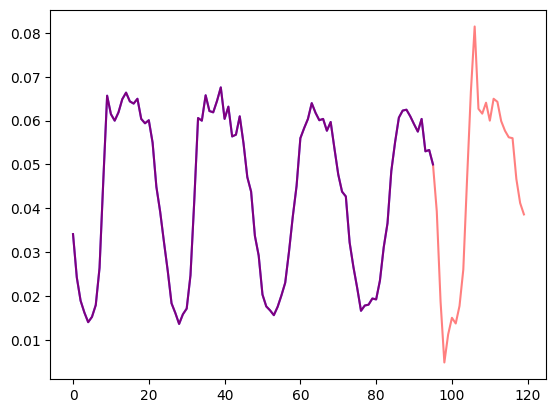

In [18]:
import matplotlib.pyplot as plt

train_example = next(iter(dataset.train))
test_example = next(iter(dataset.test))

num_of_samples = 4*prediction_length

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    test_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()


In [19]:
train_dataset = dataset.train
test_dataset = dataset.test


# Define Transformations


In [20]:
from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create a list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


c:\Users\28968\.conda\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
from gluonts.transform import InstanceSplitter
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [22]:
from gluonts.dataset.loader import as_stacked_batches


# Create PyTorch DataLoaders

In [23]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


# Evaluate on Autoformer

In [24]:
from transformers import AutoformerConfig, AutoformerForPrediction

config = AutoformerConfig.from_pretrained("kashif/autoformer-traffic-hourly")
model = AutoformerForPrediction.from_pretrained("kashif/autoformer-traffic-hourly")

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)


c:\Users\28968\.conda\envs\thesis\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [25]:
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
model.to(device)
model.eval()

forecasts_ = []
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())


In [26]:
forecasts_[0].shape



(64, 100, 24)

In [27]:
import numpy as np

forecasts = np.vstack(forecasts_)
print(forecasts.shape)



(6034, 100, 24)


In [29]:
from tqdm.autonotebook import tqdm
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
for item_id, ts in enumerate(tqdm(test_dataset)):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])


100%|██████████| 6034/6034 [00:37<00:00, 160.66it/s]


In [30]:
print(f"Autoformer univariate MASE: {np.mean(mase_metrics):.3f}")



Autoformer univariate MASE: 0.849


In [31]:
import matplotlib.dates as mdates
import pandas as pd

test_ds = list(test_dataset)

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_ds[ts_index][FieldName.START],
        periods=len(test_ds[ts_index][FieldName.TARGET]),
        freq=test_ds[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.plot(
        index[-5*prediction_length:], 
        test_ds[ts_index]["target"][-5*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.gcf().autofmt_xdate()
    plt.legend(loc="best")
    plt.show()


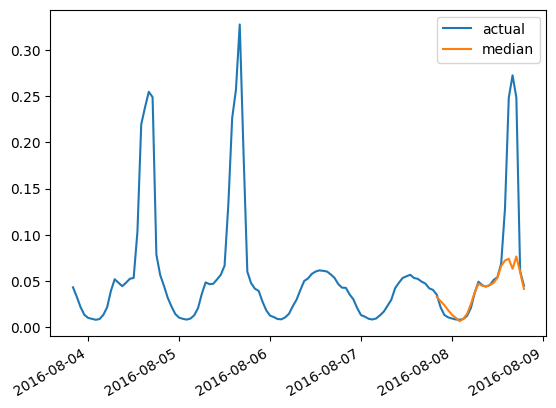

In [33]:
plot(5)


# Evaluate on DLinear


In [34]:
from gluonts.torch.model.d_linear.estimator import DLinearEstimator

# Define the DLinear model with the same parameters as the Autoformer model
estimator = DLinearEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    scaling=scaling,
    hidden_dimension=2,
    
    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    trainer_kwargs=dict(max_epochs=epochs)
)


In [35]:
predictor = estimator.train(
    training_data=train_dataset, 
    cache_data=True, 
    shuffle_buffer_length=1024
)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\28968\.conda\envs\thesis\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to en

Epoch 0: |          | 100/? [00:02<00:00, 34.88it/s, v_num=4, train_loss=-2.03]

INFO: Epoch 0, global step 100: 'train_loss' reached -2.03015 (best -2.03015), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=0-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 100: 'train_loss' reached -2.03015 (best -2.03015), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=0-step=100.ckpt' as top 1


Epoch 1: |          | 100/? [00:02<00:00, 39.52it/s, v_num=4, train_loss=-2.43]

INFO: Epoch 1, global step 200: 'train_loss' reached -2.43068 (best -2.43068), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=1-step=200.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 200: 'train_loss' reached -2.43068 (best -2.43068), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=1-step=200.ckpt' as top 1


Epoch 2: |          | 100/? [00:02<00:00, 43.79it/s, v_num=4, train_loss=-2.61]

INFO: Epoch 2, global step 300: 'train_loss' reached -2.61004 (best -2.61004), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=2-step=300.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 300: 'train_loss' reached -2.61004 (best -2.61004), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=2-step=300.ckpt' as top 1


Epoch 3: |          | 100/? [00:02<00:00, 41.96it/s, v_num=4, train_loss=-2.69]

INFO: Epoch 3, global step 400: 'train_loss' reached -2.69212 (best -2.69212), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=3-step=400.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 400: 'train_loss' reached -2.69212 (best -2.69212), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=3-step=400.ckpt' as top 1


Epoch 4: |          | 100/? [00:02<00:00, 44.98it/s, v_num=4, train_loss=-2.78]

INFO: Epoch 4, global step 500: 'train_loss' reached -2.78260 (best -2.78260), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=4-step=500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 500: 'train_loss' reached -2.78260 (best -2.78260), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=4-step=500.ckpt' as top 1


Epoch 5: |          | 100/? [00:02<00:00, 41.18it/s, v_num=4, train_loss=-2.85]

INFO: Epoch 5, global step 600: 'train_loss' reached -2.85162 (best -2.85162), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=5-step=600.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 600: 'train_loss' reached -2.85162 (best -2.85162), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=5-step=600.ckpt' as top 1


Epoch 6: |          | 100/? [00:02<00:00, 43.26it/s, v_num=4, train_loss=-2.88]

INFO: Epoch 6, global step 700: 'train_loss' reached -2.87630 (best -2.87630), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=6-step=700.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 700: 'train_loss' reached -2.87630 (best -2.87630), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=6-step=700.ckpt' as top 1


Epoch 7: |          | 100/? [00:02<00:00, 38.65it/s, v_num=4, train_loss=-2.90]

INFO: Epoch 7, global step 800: 'train_loss' reached -2.89779 (best -2.89779), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=7-step=800.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 800: 'train_loss' reached -2.89779 (best -2.89779), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=7-step=800.ckpt' as top 1


Epoch 8: |          | 100/? [00:02<00:00, 40.32it/s, v_num=4, train_loss=-2.92]

INFO: Epoch 8, global step 900: 'train_loss' reached -2.91524 (best -2.91524), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=8-step=900.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 900: 'train_loss' reached -2.91524 (best -2.91524), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=8-step=900.ckpt' as top 1


Epoch 9: |          | 100/? [00:02<00:00, 39.10it/s, v_num=4, train_loss=-2.92]

INFO: Epoch 9, global step 1000: 'train_loss' reached -2.91545 (best -2.91545), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=9-step=1000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 1000: 'train_loss' reached -2.91545 (best -2.91545), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=9-step=1000.ckpt' as top 1


Epoch 10: |          | 100/? [00:02<00:00, 38.42it/s, v_num=4, train_loss=-2.93]

INFO: Epoch 10, global step 1100: 'train_loss' reached -2.92949 (best -2.92949), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=10-step=1100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 1100: 'train_loss' reached -2.92949 (best -2.92949), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=10-step=1100.ckpt' as top 1


Epoch 11: |          | 100/? [00:02<00:00, 38.15it/s, v_num=4, train_loss=-2.94]

INFO: Epoch 11, global step 1200: 'train_loss' reached -2.93730 (best -2.93730), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=11-step=1200.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 1200: 'train_loss' reached -2.93730 (best -2.93730), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=11-step=1200.ckpt' as top 1


Epoch 12: |          | 100/? [00:02<00:00, 40.50it/s, v_num=4, train_loss=-2.94]

INFO: Epoch 12, global step 1300: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 1300: 'train_loss' was not in top 1


Epoch 13: |          | 100/? [00:02<00:00, 38.30it/s, v_num=4, train_loss=-2.93]

INFO: Epoch 13, global step 1400: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 1400: 'train_loss' was not in top 1


Epoch 14: |          | 100/? [00:02<00:00, 38.33it/s, v_num=4, train_loss=-2.93]

INFO: Epoch 14, global step 1500: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 1500: 'train_loss' was not in top 1


Epoch 15: |          | 100/? [00:02<00:00, 38.57it/s, v_num=4, train_loss=-2.93]

INFO: Epoch 15, global step 1600: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 1600: 'train_loss' was not in top 1


Epoch 16: |          | 100/? [00:02<00:00, 40.89it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 16, global step 1700: 'train_loss' reached -2.94775 (best -2.94775), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=16-step=1700.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 1700: 'train_loss' reached -2.94775 (best -2.94775), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=16-step=1700.ckpt' as top 1


Epoch 17: |          | 100/? [00:02<00:00, 39.63it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 17, global step 1800: 'train_loss' reached -2.96252 (best -2.96252), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=17-step=1800.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 1800: 'train_loss' reached -2.96252 (best -2.96252), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=17-step=1800.ckpt' as top 1


Epoch 18: |          | 100/? [00:02<00:00, 40.12it/s, v_num=4, train_loss=-2.94]

INFO: Epoch 18, global step 1900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 1900: 'train_loss' was not in top 1


Epoch 19: |          | 100/? [00:02<00:00, 40.18it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 19, global step 2000: 'train_loss' reached -2.96258 (best -2.96258), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=19-step=2000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 2000: 'train_loss' reached -2.96258 (best -2.96258), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=19-step=2000.ckpt' as top 1


Epoch 20: |          | 100/? [00:02<00:00, 39.53it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 20, global step 2100: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 2100: 'train_loss' was not in top 1


Epoch 21: |          | 100/? [00:02<00:00, 40.30it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 21, global step 2200: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 2200: 'train_loss' was not in top 1


Epoch 22: |          | 100/? [00:02<00:00, 39.15it/s, v_num=4, train_loss=-2.94]

INFO: Epoch 22, global step 2300: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 2300: 'train_loss' was not in top 1


Epoch 23: |          | 100/? [00:02<00:00, 37.30it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 23, global step 2400: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 2400: 'train_loss' was not in top 1


Epoch 24: |          | 100/? [00:02<00:00, 39.54it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 24, global step 2500: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 2500: 'train_loss' was not in top 1


Epoch 25: |          | 100/? [00:02<00:00, 39.13it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 25, global step 2600: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 2600: 'train_loss' was not in top 1


Epoch 26: |          | 100/? [00:02<00:00, 37.39it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 26, global step 2700: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 2700: 'train_loss' was not in top 1


Epoch 27: |          | 100/? [00:02<00:00, 37.18it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 27, global step 2800: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 2800: 'train_loss' was not in top 1


Epoch 28: |          | 100/? [00:02<00:00, 43.52it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 28, global step 2900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 2900: 'train_loss' was not in top 1


Epoch 29: |          | 100/? [00:02<00:00, 43.12it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 29, global step 3000: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 3000: 'train_loss' was not in top 1


Epoch 30: |          | 100/? [00:02<00:00, 41.76it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 30, global step 3100: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 30, global step 3100: 'train_loss' was not in top 1


Epoch 31: |          | 100/? [00:02<00:00, 40.39it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 31, global step 3200: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 31, global step 3200: 'train_loss' was not in top 1


Epoch 32: |          | 100/? [00:02<00:00, 38.48it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 32, global step 3300: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 32, global step 3300: 'train_loss' was not in top 1


Epoch 33: |          | 100/? [00:02<00:00, 37.96it/s, v_num=4, train_loss=-2.97]

INFO: Epoch 33, global step 3400: 'train_loss' reached -2.97054 (best -2.97054), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=33-step=3400.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 33, global step 3400: 'train_loss' reached -2.97054 (best -2.97054), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=33-step=3400.ckpt' as top 1


Epoch 34: |          | 100/? [00:02<00:00, 38.11it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 34, global step 3500: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 34, global step 3500: 'train_loss' was not in top 1


Epoch 35: |          | 100/? [00:02<00:00, 40.58it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 35, global step 3600: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 35, global step 3600: 'train_loss' was not in top 1


Epoch 36: |          | 100/? [00:02<00:00, 39.58it/s, v_num=4, train_loss=-2.97]

INFO: Epoch 36, global step 3700: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 36, global step 3700: 'train_loss' was not in top 1


Epoch 37: |          | 100/? [00:02<00:00, 39.44it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 37, global step 3800: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 37, global step 3800: 'train_loss' was not in top 1


Epoch 38: |          | 100/? [00:02<00:00, 36.33it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 38, global step 3900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 38, global step 3900: 'train_loss' was not in top 1


Epoch 39: |          | 100/? [00:02<00:00, 38.16it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 39, global step 4000: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 39, global step 4000: 'train_loss' was not in top 1


Epoch 40: |          | 100/? [00:02<00:00, 38.73it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 40, global step 4100: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 40, global step 4100: 'train_loss' was not in top 1


Epoch 41: |          | 100/? [00:02<00:00, 38.43it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 41, global step 4200: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 41, global step 4200: 'train_loss' was not in top 1


Epoch 42: |          | 100/? [00:02<00:00, 38.06it/s, v_num=4, train_loss=-2.95]

INFO: Epoch 42, global step 4300: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 42, global step 4300: 'train_loss' was not in top 1


Epoch 43: |          | 100/? [00:02<00:00, 38.67it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 43, global step 4400: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 43, global step 4400: 'train_loss' was not in top 1


Epoch 44: |          | 100/? [00:02<00:00, 39.50it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 44, global step 4500: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 44, global step 4500: 'train_loss' was not in top 1


Epoch 45: |          | 100/? [00:02<00:00, 38.06it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 45, global step 4600: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 45, global step 4600: 'train_loss' was not in top 1


Epoch 46: |          | 100/? [00:02<00:00, 36.10it/s, v_num=4, train_loss=-2.97]

INFO: Epoch 46, global step 4700: 'train_loss' reached -2.97454 (best -2.97454), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=46-step=4700.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 46, global step 4700: 'train_loss' reached -2.97454 (best -2.97454), saving model to 'd:\\studydata\\Autoformer\\Autoformer\\lightning_logs\\version_4\\checkpoints\\epoch=46-step=4700.ckpt' as top 1


Epoch 47: |          | 100/? [00:02<00:00, 36.95it/s, v_num=4, train_loss=-2.97]

INFO: Epoch 47, global step 4800: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 47, global step 4800: 'train_loss' was not in top 1


Epoch 48: |          | 100/? [00:02<00:00, 37.43it/s, v_num=4, train_loss=-2.97]

INFO: Epoch 48, global step 4900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 48, global step 4900: 'train_loss' was not in top 1


Epoch 49: |          | 100/? [00:02<00:00, 37.82it/s, v_num=4, train_loss=-2.96]

INFO: Epoch 49, global step 5000: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 49, global step 5000: 'train_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 100/? [00:02<00:00, 37.70it/s, v_num=4, train_loss=-2.96]


In [36]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

d_linear_forecasts = list(forecast_it)
d_linear_tss = list(ts_it)

evaluator = Evaluator()

agg_metrics, _ = evaluator(iter(d_linear_tss), iter(d_linear_forecasts))


Running evaluation: 6034it [02:15, 44.46it/s]
c:\Users\28968\.conda\envs\thesis\lib\site-packages\pandas\core\dtypes\astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [37]:
dlinear_mase = agg_metrics["MASE"]
print(f"DLinear MASE: {dlinear_mase:.3f}")



DLinear MASE: 0.967


In [38]:
def plot_gluonts(index):
    plt.plot(d_linear_tss[index][-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    d_linear_forecasts[index].plot(show_label=True,  color='g')
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()


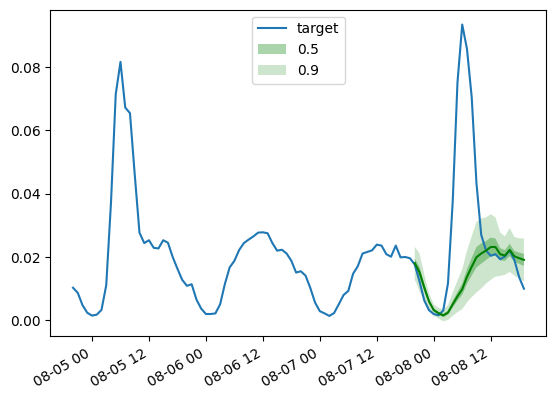

In [39]:
plot_gluonts(4)
